# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [8]:
import pandas as pd
import numpy as np
import math
import json
import datetime
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

# read in the json files
portfolio = pd.read_json('Data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('Data/profile.json', orient='records', lines=True)
transcript = pd.read_json('Data/transcript.json', orient='records', lines=True)

In [9]:
import re

In [10]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [11]:
def clean_portfolio(portfolio):
    
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    offer_type = pd.get_dummies(portfolio['offer_type'])
    
    channels_type = ['web','email','mobile','social']
    
    for channel in channels_type:
        portfolio[channel] = portfolio['channels'].apply(lambda x: 1 if channel in x else 0)
        
    portfolio.drop(['channels','offer_type'], axis = 1, inplace = True)
    
    cleaned_portfolio = pd.concat([portfolio,offer_type], axis = 1, sort = False)
    
    return cleaned_portfolio

cleaned_portfolio = clean_portfolio(portfolio)
cleaned_portfolio.head()

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0


In [12]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [13]:
def clean_profile(profile):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    profile['age'] = profile['age'].apply(lambda x : np.nan if x == 118 else x)
    profile['member_days'] = datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    
    profile['member_days'] = profile['member_days'].dt.days
    
    return profile

cleaned_profile = clean_profile(profile)
cleaned_profile.head()

,age,became_member_on,gender,id,income,member_days
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1072
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,919
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,557
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,986
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,899


In [14]:
cleaned_profile.describe()

,age,became_member_on,income,member_days
count,14825.000000,1.700000e+04,14825.000000,17000.000000
mean,54.393524,2.016703e+07,65404.991568,1060.449882
std,17.383705,1.167750e+04,21598.299410,411.223904
min,18.000000,2.013073e+07,30000.000000,543.000000
25%,42.000000,2.016053e+07,49000.000000,751.000000
50%,55.000000,2.017080e+07,64000.000000,901.000000
75%,66.000000,2.017123e+07,80000.000000,1334.000000
max,101.000000,2.018073e+07,120000.000000,2366.000000


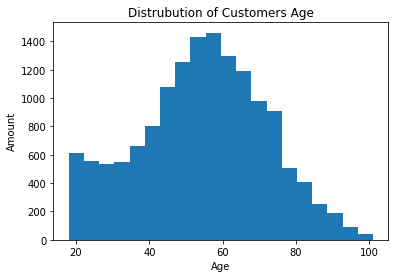

In [15]:
user_age = cleaned_profile['age'].plot(kind='hist', bins=20, title='Distrubution of Customers Age')
user_age.set_xlabel("Age")
user_age.set_ylabel("Amount");

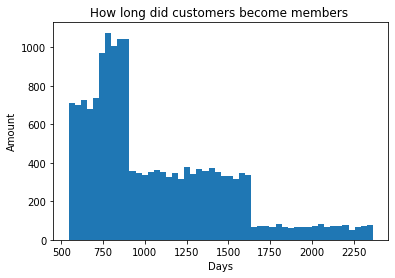

In [16]:
memberdays = cleaned_profile['member_days'].plot(kind = 'hist', bins = 50, title = 'How long did customers become members ')
memberdays.set_xlabel('Days')
memberdays.set_ylabel('Amount');

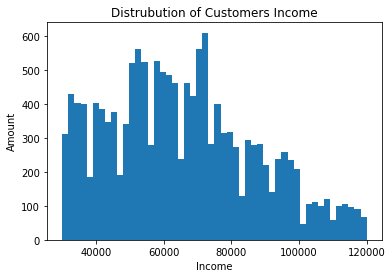

In [17]:
user_age = cleaned_profile['income'].plot(kind='hist', bins=50, title='Distrubution of Customers Income')
user_age.set_xlabel("Income")
user_age.set_ylabel("Amount");

In [18]:
transcript.head(10)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
6,offer received,c4863c7985cf408faee930f111475da3,0,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
9,offer received,31dda685af34476cad5bc968bdb01c53,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [19]:
event_type = transcript['event'].unique().tolist()
event_type

['offer received', 'offer viewed', 'transaction', 'offer completed']

In [27]:
def clean_transcript(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    offer['offer_id'] = offer['value'].apply(lambda x: re.sub("{'offer id': '","", str(x)))
    offer['offer_id'] = offer['offer_id'].apply(lambda x: re.sub("{'offer_id': '","", str(x)))
    offer['offer_id'] = offer['offer_id'].apply(lambda x: re.sub("'}","",x))
    offer['reward'] = offer['offer_id'].apply(lambda x: re.findall(r'\d', x)[-1] if 'reward' in x else np.nan)    
    offer['offer_id'] = offer['offer_id'].apply(lambda x: re.sub(r"', 'reward': \d+}","", x))
        
    event_type = ['offer received', 'offer viewed', 'transaction', 'offer completed']
    for even in event_type:
        offer[even] = offer['event'].apply(lambda x: 1 if x == even else 0 )
    
    offer.drop(['value'], axis = 1, inplace = True)
    
    return offer

offer = clean_transcript(transcript)
offer.head()

/Users/chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/chen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

,event,person,time,offer_id,reward,offer received,offer viewed,transaction,offer completed
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,0,0,0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,0,0
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,1,0,0,0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,1,0,0,0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,1,0,0,0


In [28]:
# check how many times the offer has sent
offer[offer['offer received'] == 1]['time'].unique()

array([  0, 168, 336, 408, 504, 576])

In [29]:
offer[offer['person']=='0009655768c64bdeb2e877511632db8f']

,event,person,time,offer_id,reward,offer received,offer viewed,transaction,offer completed
55972,offer received,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,NaN,1,0,0,0
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,5a8bc65990b245e5a138643cd4eb9837,NaN,0,1,0,0
113605,offer received,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,NaN,1,0,0,0
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,3f207df678b143eea3cee63160fa8bed,NaN,0,1,0,0
153401,offer received,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1,0,0,0
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,f19421c1d4aa40978ebb69ca19b0e20d,5,0,0,0,1
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,f19421c1d4aa40978ebb69ca19b0e20d,NaN,0,1,0,0
204340,offer received,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,NaN,1,0,0,0
228423,offer completed,0009655768c64bdeb2e877511632db8f,528,fafdcd668e3743c1bb461111dcafc2a4,2,0,0,0,1
233413,offer viewed,0009655768c64bdeb2e877511632db8f,540,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0


In [30]:
offer.shape

(167581, 9)

In [31]:
def create_user_item_matrix(offer, filename):
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # we just focus on bogo and discount first
    user_item_matrix.drop(list(cleaned_portfolio[cleaned_portfolio['informational']==1]['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    
    return user_item_matrix

In [32]:
full_df = create_user_item_matrix(offer, 'user_item_matrix.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [34]:
full_df.head(10)

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN
003d66b6608740288d6cc97a6903f4f0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2.0
00426fe3ffde4c6b9cb9ad6d077a13ea,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.0
004b041fbfe44859945daa2c7f79ee64,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
004c5799adbf42868b9cff0396190900,NaN,NaN,NaN,NaN,NaN,0.0,2.0,1.0


In [35]:
train_size = int(offer.shape[0]*0.7)
test_size = offer.shape[0] - train_size
train_size, test_size

(117306, 50275)

In [36]:
train_offer = offer[:train_size]

In [37]:
test_offer = offer[train_size:]

In [38]:
train_df = create_user_item_matrix(train_offer, 'train_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [39]:
 train_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN


In [40]:
test_df = create_user_item_matrix(test_offer, 'test_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128

In [41]:
test_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [46]:
 def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    
    '''
    
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = n_users * n_offers
    
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    sse_accum = 0
    
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")

    for iteration in range(iters):
        old_sse = sse_accum
        sse_accum = 0
        
        for i in range(n_users):
            for j in range(n_offers):
                if complete_mat[i,j] >= 0:
                    diffs = complete_mat[i,j] - np.dot(user_mat[i,:], offer_mat[:,j])
                    sse_accum += diffs ** 2
                    for k in range(latent_features):
                        user_mat[i,k] += learning_rate*(diffs*2*offer_mat[k,j])
                        offer_mat[k,j] += learning_rate*(diffs*2*user_mat[i,k])
                        
        print(" %d \t\t %f" %(iteration+1, sse_accum/num_complete))
        
    return user_mat, offer_mat

In [47]:
# Create user-by-item matrix - nothing to do here
train_data_np = np.array(train_df)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=250)

Optimization Statistics
Iterations | Mean Squared Error 
 1 		 0.092998
 2 		 0.080393
 3 		 0.080292
 4 		 0.080186
 5 		 0.080079
 6 		 0.079971
 7 		 0.079861
 8 		 0.079750
 9 		 0.079638
 10 		 0.079525
 11 		 0.079409
 12 		 0.079293
 13 		 0.079174
 14 		 0.079053
 15 		 0.078931
 16 		 0.078806
 17 		 0.078679
 18 		 0.078549
 19 		 0.078417
 20 		 0.078282
 21 		 0.078144
 22 		 0.078002
 23 		 0.077857
 24 		 0.077709
 25 		 0.077556
 26 		 0.077399
 27 		 0.077237
 28 		 0.077071
 29 		 0.076899
 30 		 0.076722
 31 		 0.076539
 32 		 0.076350
 33 		 0.076154
 34 		 0.075950
 35 		 0.075740
 36 		 0.075521
 37 		 0.075293
 38 		 0.075057
 39 		 0.074810
 40 		 0.074554
 41 		 0.074286
 42 		 0.074007
 43 		 0.073716
 44 		 0.073413
 45 		 0.073095
 46 		 0.072764
 47 		 0.072417
 48 		 0.072055
 49 		 0.071677
 50 		 0.071281
 51 		 0.070867
 52 		 0.070435
 53 		 0.069983
 54 		 0.069511
 55 		 0.069018
 56 		 0.068503
 57 		 0.067966
 58 		 0.067406
 59 		 0.066823
 60 		 0

In [48]:
# Test for the best number of latent feature. (with latent features 10)
user_mat_10, offer_mat_10 = FunkSVD(train_data_np, latent_features=10, learning_rate=0.005, iters=250)

Optimization Statistics
Iterations | Mean Squared Error 
 1 		 0.089853
 2 		 0.080238
 3 		 0.080102
 4 		 0.079962
 5 		 0.079822
 6 		 0.079681
 7 		 0.079539
 8 		 0.079397
 9 		 0.079254
 10 		 0.079110
 11 		 0.078966
 12 		 0.078821
 13 		 0.078675
 14 		 0.078528
 15 		 0.078380
 16 		 0.078231
 17 		 0.078081
 18 		 0.077929
 19 		 0.077776
 20 		 0.077622
 21 		 0.077467
 22 		 0.077309
 23 		 0.077150
 24 		 0.076989
 25 		 0.076827
 26 		 0.076662
 27 		 0.076495
 28 		 0.076325
 29 		 0.076153
 30 		 0.075979
 31 		 0.075801
 32 		 0.075620
 33 		 0.075436
 34 		 0.075249
 35 		 0.075058
 36 		 0.074863
 37 		 0.074664
 38 		 0.074460
 39 		 0.074252
 40 		 0.074038
 41 		 0.073820
 42 		 0.073595
 43 		 0.073365
 44 		 0.073128
 45 		 0.072885
 46 		 0.072635
 47 		 0.072378
 48 		 0.072112
 49 		 0.071839
 50 		 0.071556
 51 		 0.071265
 52 		 0.070964
 53 		 0.070654
 54 		 0.070332
 55 		 0.070000
 56 		 0.069657
 57 		 0.069302
 58 		 0.068935
 59 		 0.068555
 60 		 0

In [49]:
# Test for the best number of latent feature. (with latent features 5)
user_mat_5, offer_mat_5 = FunkSVD(train_data_np, latent_features=5, learning_rate=0.005, iters=250)

Optimization Statistics
Iterations | Mean Squared Error 
 1 		 0.084182
 2 		 0.080911
 3 		 0.080656
 4 		 0.080401
 5 		 0.080145
 6 		 0.079889
 7 		 0.079632
 8 		 0.079376
 9 		 0.079119
 10 		 0.078862
 11 		 0.078604
 12 		 0.078346
 13 		 0.078087
 14 		 0.077828
 15 		 0.077569
 16 		 0.077309
 17 		 0.077049
 18 		 0.076788
 19 		 0.076527
 20 		 0.076264
 21 		 0.076002
 22 		 0.075738
 23 		 0.075474
 24 		 0.075208
 25 		 0.074942
 26 		 0.074675
 27 		 0.074407
 28 		 0.074138
 29 		 0.073867
 30 		 0.073596
 31 		 0.073323
 32 		 0.073048
 33 		 0.072772
 34 		 0.072494
 35 		 0.072215
 36 		 0.071933
 37 		 0.071650
 38 		 0.071364
 39 		 0.071076
 40 		 0.070786
 41 		 0.070493
 42 		 0.070198
 43 		 0.069900
 44 		 0.069598
 45 		 0.069294
 46 		 0.068986
 47 		 0.068675
 48 		 0.068360
 49 		 0.068042
 50 		 0.067719
 51 		 0.067392
 52 		 0.067061
 53 		 0.066725
 54 		 0.066385
 55 		 0.066039
 56 		 0.065689
 57 		 0.065333
 58 		 0.064972
 59 		 0.064605
 60 		 0

In [50]:
# Test for the best number of iters. (with iters 500)
user_mat_500, offer_mat_500 = FunkSVD(train_data_np, latent_features=10, learning_rate=0.005, iters=500)

Optimization Statistics
Iterations | Mean Squared Error 
 1 		 0.088792
 2 		 0.080024
 3 		 0.079882
 4 		 0.079739
 5 		 0.079595
 6 		 0.079450
 7 		 0.079305
 8 		 0.079158
 9 		 0.079010
 10 		 0.078861
 11 		 0.078711
 12 		 0.078559
 13 		 0.078406
 14 		 0.078251
 15 		 0.078094
 16 		 0.077936
 17 		 0.077776
 18 		 0.077613
 19 		 0.077448
 20 		 0.077281
 21 		 0.077111
 22 		 0.076938
 23 		 0.076763
 24 		 0.076584
 25 		 0.076401
 26 		 0.076215
 27 		 0.076025
 28 		 0.075831
 29 		 0.075632
 30 		 0.075429
 31 		 0.075220
 32 		 0.075006
 33 		 0.074786
 34 		 0.074560
 35 		 0.074327
 36 		 0.074087
 37 		 0.073840
 38 		 0.073585
 39 		 0.073322
 40 		 0.073051
 41 		 0.072770
 42 		 0.072479
 43 		 0.072178
 44 		 0.071867
 45 		 0.071544
 46 		 0.071210
 47 		 0.070863
 48 		 0.070504
 49 		 0.070132
 50 		 0.069745
 51 		 0.069345
 52 		 0.068930
 53 		 0.068500
 54 		 0.068054
 55 		 0.067593
 56 		 0.067115
 57 		 0.066621
 58 		 0.066110
 59 		 0.065582
 60 		 0

 486 		 0.000019
 487 		 0.000019
 488 		 0.000019
 489 		 0.000018
 490 		 0.000018
 491 		 0.000018
 492 		 0.000018
 493 		 0.000018
 494 		 0.000018
 495 		 0.000017
 496 		 0.000017
 497 		 0.000017
 498 		 0.000017
 499 		 0.000017
 500 		 0.000017


In [81]:
def predict_reaction(user_matrix, offer_matrix, user_id, offer_id):
    '''
    We can use this to make predictions for how users would react with the offers
    
    INPUT:
    user_matrix - user by latent factor matrix
    offer_matrix - latent factor by offer matrix
    user_id - the user_id from the reviews df
    offer_id - the offer_id according the offers df
    
    OUTPUT:
    pred - the predicted reaction for user_id-offer_id according to FunkSVD
    '''
    try:
        user_id_series = np.array(train_df.index)
        offer_id_series = np.array(train_df.columns)

        user_row = np.where(user_id_series == str(user_id))[0][0]
        offer_column = np.where(offer_id_series == str(offer_id))[0][0]

        pred = np.dot(user_matrix[user_row,:], offer_matrix[:,offer_column])

        return pred
   
    except:
        #print('Enable to make a prediction. It looks like one of these items does not exist in our current database.')
        
    
        return None
        

In [80]:
predict_reaction(user_mat, offer_mat, '0011e0d4e6b944f998e987f904e8c1e5', '2298d6c36e964ae4a3e7e9706d1fb8c2')

1.0107176818574295

In [84]:
def validation(test_df, user_mat, offer_mat):
    '''Measure the squared errors for the prediction'''
    
    num_complete = test_df.shape[0] * test_df.shape[1]
    sse_accum = 0
    
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id,offer_id]):
                pred = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                if pred != None:
                    diffs = test_df.loc[user_id,offer_id] - pred
                    sse_accum += diffs ** 2
                    
                    
    return sse_accum/num_complete

In [85]:
# Evaluation for latent features of 15
validation(test_df, user_mat, offer_mat)

0.054184469075440916

In [86]:
# Evaluation for latent features of 10
validation(test_df, user_mat_10, offer_mat_10)

0.050715915822619764

In [87]:
# Evaluation for latent features of 5
validation(test_df, user_mat_5, offer_mat_5)

0.05207761203382659

In [88]:
# Evaluation for iters of 500
validation(test_df, user_mat_500, offer_mat_500)

0.053574726120805855

In [113]:
def best_sale_offer(user_item_matrix):    
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    
    return offer_value

                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94


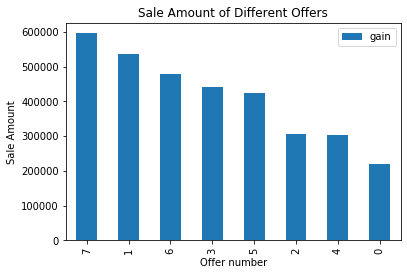

In [100]:
offer_value = best_sale_offer(full_df)
best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
best_sale.set_xlabel('Offer number')
best_sale.set_ylabel('Sale Amount');

In [101]:
recommend = {}
len(recommend)

0

In [120]:
def recommend_offer(user_id, user_mat, offer_mat):
    
    top_offer = best_sale_offer(full_df)
    recommend = {}
    
    for offer_id in full_df.columns:
        pred = predict_reaction(user_mat, offer_mat, user_id, offer_id)
        if pred != None:
            recommend[offer_id] = pred
                
    if len(recommend) == 0:
        print('Cause there is no enough data for user in the database, here is the rank of best sale offers:')
        for offer_id in top_offer['offer_id']:
            print('Offer id: ',offer_id)
        
    else:
        print("Recommend offer for user ", user_id)
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse=True):
            print('Offer id:', offer_id, 'Predicton value:', round(pred_val,2))
            
    

In [116]:
recommend_offer('0610b486422d4921ae7d2bf64640c50b', user_mat, offer_mat)

Recommend offer for user  0610b486422d4921ae7d2bf64640c50b
Offer id: 2298d6c36e964ae4a3e7e9706d1fb8c2 Predicton value: 1.09
Offer id: fafdcd668e3743c1bb461111dcafc2a4 Predicton value: 0.67
Offer id: 4d5c57ea9a6940dd891ad53e9dbe8da0 Predicton value: 0.5
Offer id: ae264e3637204a6fb9bb56bc8210ddfd Predicton value: 0.48
Offer id: 9b98b8c7a33c4b65b9aebfe6a799e6d9 Predicton value: 0.06
Offer id: 2906b810c7d4411798c6938adc9daaa5 Predicton value: -0.03
Offer id: f19421c1d4aa40978ebb69ca19b0e20d Predicton value: -0.04
Offer id: 0b1e1539f2cc45b7b9fa7c272da2e1d7 Predicton value: -0.25


In [121]:
recommend_offer('new_user', user_mat, offer_mat)

Cause there is no enough data for user in the database, here is the rank of best sale offers:
Offer id:  fafdcd668e3743c1bb461111dcafc2a4
Offer id:  2298d6c36e964ae4a3e7e9706d1fb8c2
Offer id:  f19421c1d4aa40978ebb69ca19b0e20d
Offer id:  4d5c57ea9a6940dd891ad53e9dbe8da0
Offer id:  ae264e3637204a6fb9bb56bc8210ddfd
Offer id:  2906b810c7d4411798c6938adc9daaa5
Offer id:  9b98b8c7a33c4b65b9aebfe6a799e6d9
Offer id:  0b1e1539f2cc45b7b9fa7c272da2e1d7


In [126]:
cleaned_portfolio.head(10)

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [135]:
profile.head()

,age,became_member_on,gender,id,income,member_days
0,NaN,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,1072
1,55.0,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0,919
2,NaN,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,557
3,75.0,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,986
4,NaN,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN,899


,bogo,discount
M,37.355868,44.364867
F,51.390568,50.922064
O,56.765677,57.755776


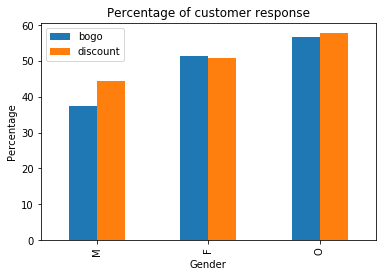

In [144]:
def gender_offer(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    # initialize the gender response and the gender sent dataframe
    gender_response = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
    gender_sent = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
    
    for offer_type in ['bogo', 'discount']:
        for offer_id in cleaned_portfolio[cleaned_portfolio[offer_type] == 1]['id']:
            gender_response[offer_type] = gender_response[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value = 0)
            gender_sent[offer_type] = gender_sent[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value = 0)
    
    gender_offer = (gender_response / gender_sent * 100)
    fig = gender_offer.plot(kind = 'bar', title='Percentage of customer response')
    fig.set_xlabel('Gender')
    fig.set_ylabel('Percentage')
    
    
    return gender_offer

gender_offer(full_df)

,web,email,mobile,social
M,41.795219,40.866446,43.987741,49.254013
F,51.209247,51.156149,55.133535,62.407211
O,58.712121,57.260726,59.357278,62.702703


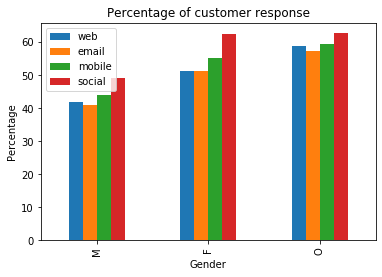

In [145]:
def gender_offer_channel(full_df):
    '''
    Find out which type of offer (bogo/discount) attracts most to different gender
    Return with a plotted bar chart
    '''
    
    gender_response = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
    gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

    for channel_type in ['web', 'email', 'mobile', 'social']:
        for offer_id in cleaned_portfolio[(cleaned_portfolio[channel_type]==1)&(cleaned_portfolio['informational']!=1)]['id']:
            gender_response[channel_type] = gender_response[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            gender_sent[channel_type] = gender_sent[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100)
    fig = gender_offer.plot(kind = 'bar', title='Percentage of customer response')
    fig.set_xlabel('Gender')
    fig.set_ylabel('Percentage')
    
    
    return gender_offer

gender_offer_channel(full_df)